<a href="https://colab.research.google.com/github/alexsuakim/Computer-Vision/blob/main/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# You may need to run the following code to use SIFT (especially on google colab)
#!pip install opencv-contrib-python==4.5.5.62
#!pip3 install matplotlib
#!pip install imutils
#!pip install -U scikit-learn
#!pip install -U scikit-image
#!pip install mlxtend
#!pip install tqdm


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import numpy as np
import imutils
import tarfile
import copy
import random
from pathlib import Path
from skimage.color import rgb2gray
from mlxtend.plotting import plot_decision_regions
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, precision_score, recall_score
from sklearn.cluster import KMeans
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.utils import image_dataset_from_directory, normalize
from keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dense
from keras import Sequential
from keras.losses import SparseCategoricalCrossentropy

**Q3 (1)**

a)

this is an example of a loaded image
the size of an image is: (200, 267)


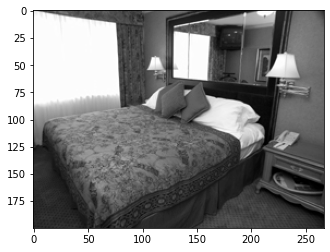

In [ ]:
#load images into lists
def load_images(directory):
    images = []
    img_class = []
    #there are 15 categories of pictures
    categories = [d for d in directory.iterdir()]
    #iterate categories and images and store images in a list in grayscale
    for i, categ in enumerate(categories):
        for file in categ.iterdir():
            img = cv2.imread(str(file), cv2.IMREAD_GRAYSCALE)
            img = img
            images.append(img)
            img_class.append(i)

    return images, img_class

#path for training set
train_path = r'C:\Users\Sua\Desktop\STAT3010\a2\a2\Q3\data\train'
train_dir = Path(train_path)

#path for testing set
test_path = r'C:\Users\Sua\Desktop\STAT3010\a2\a2\Q3\data\test'
test_dir = Path(test_path)

#classes of categories
categories = [directory.name for directory in train_dir.iterdir()]
#number of classes/categories
n_classes = len(categories)

#load images and store them into arrays
train_img, Y_train = load_images(train_dir)
test_img, Y_test = load_images(test_dir)

#print the outcome
print("this is an example of a loaded image")
plt.imshow(train_img[0], cmap='gray')
print(f'the size of an image is: {train_img[0].shape}')

In [ ]:
# compute sift with a 4 pixel-stride
def dense_sift(image_set):
    sift = cv2.xfeatures2d.SIFT_create()
    sift_features = []
    step_size = 20
    for img in image_set:
        kp = [cv2.KeyPoint(x, y, step_size) for x in range(0, img.shape[0], step_size)
                                            for y in range(0, img.shape[1], step_size)]
        kp, des = sift.compute(img, kp)
        sift_features.append(des)
    return sift_features


In [ ]:
# extract sift features from training and testing images
X_train = dense_sift(train_img)
X_test = dense_sift(test_img)

#transform X_train into an np array
descriptors = []
for i in range(len(X_train)):
    for j in range(X_train[i].shape[0]):
        descriptors.append(X_train[i][j,:])
descriptors = np.array(descriptors)

In [ ]:
#create histogram based on the feature vocabulary
def histogram(image_set, kmeans, k):
    hist = []
    for img in tqdm(image_set):
        data = copy.deepcopy(img)
        pred = kmeans.predict(data)
        hist.append(np.bincount(pred, minlength=k).reshape(1,-1).ravel())
    return np.array(hist)

In [ ]:
#clustering
k=50
kmeans = KMeans(n_clusters=k).fit(descriptors)

#compute histograms for training images
train_hist = histogram(X_train, kmeans, k)
#fit scaler to train histogram
scaler = preprocessing.StandardScaler().fit(train_hist)
train_hist = scaler.transform(train_hist) #normalise histogram to zero mean and unit variance

#compute histograms for testing images
test_hist = histogram(X_test, kmeans, k)
test_hist = scaler.transform(test_hist) #normalise histogram to zero mean and unit variance

100%|██████████| 2985/2985 [06:22<00:00,  7.80it/s]


In [ ]:
clf = LinearSVC(random_state=0, C=0.1, verbose=1)
clf.fit(train_hist, Y_train)
Y_pred = clf.predict(test_hist)
accuracy = accuracy_score(Y_test, Y_pred)
print(accuracy)

[LibLinear]0.6361809045226131


b)

In [ ]:
#split the training set into training set and validation set
X_train1, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

#re-create histograms to make sure the validation set has never been used in the training process
#clustering
k=50
kmeans = KMeans(n_clusters=k).fit(descriptors)

#compute histograms for training images
train_hist1 = histogram(X_train1, kmeans, k)
#fit scaler to train histogram
scaler = preprocessing.StandardScaler().fit(train_hist1)
train_hist1 = scaler.transform(train_hist1) #normalise histogram to zero mean and unit variance

#compute histograms for validation images
val_hist = histogram(X_val, kmeans, k)
val_hist = scaler.transform(val_hist) #normalise histogram to zero mean and unit variance

#compute histograms for testing images
test_hist = histogram(X_test, kmeans, k)
test_hist = scaler.transform(test_hist) #normalise histogram to zero mean and unit variance


In [ ]:
#find the best regularisation parameter c using validation set

for c in np.arange(0.005, 0.29, 0.005): #0.29 is when it starts to not converge
    clf = LinearSVC(random_state=0, C=c, verbose=1)
    clf.fit(train_hist1, Y_train)
    Y_pred_val = clf.predict(val_hist)
    accuracy = accuracy_score(Y_val, Y_pred_val)
    print(f'accuracy with c={c}: {accuracy}')


[LibLinear]accuracy with c=0.005: 0.58
[LibLinear]accuracy with c=0.01: 0.5866666666666667
[LibLinear]accuracy with c=0.015: 0.5933333333333334
[LibLinear]accuracy with c=0.02: 0.6066666666666667
[LibLinear]accuracy with c=0.025: 0.61
[LibLinear]accuracy with c=0.030000000000000002: 0.61
[LibLinear]accuracy with c=0.034999999999999996: 0.61
[LibLinear]accuracy with c=0.04: 0.6133333333333333
[LibLinear]accuracy with c=0.045: 0.6133333333333333
[LibLinear]accuracy with c=0.049999999999999996: 0.6133333333333333
[LibLinear]accuracy with c=0.055: 0.6166666666666667
[LibLinear]accuracy with c=0.06: 0.6133333333333333
[LibLinear]accuracy with c=0.065: 0.6133333333333333
[LibLinear]accuracy with c=0.07: 0.6133333333333333
[LibLinear]accuracy with c=0.07500000000000001: 0.61
[LibLinear]accuracy with c=0.08: 0.61
[LibLinear]accuracy with c=0.085: 0.6066666666666667
[LibLinear]accuracy with c=0.09000000000000001: 0.6066666666666667
[LibLinear]accuracy with c=0.095: 0.6066666666666667
[LibLinear

In [ ]:
#test the accuracy with the adjusted parameters using test set
clf = LinearSVC(random_state=0, C=0.125, verbose=1)
clf.fit(train_hist1, Y_train)
Y_pred = clf.predict(test_hist)
accuracy = accuracy_score(Y_test, Y_pred)
print(accuracy)


[LibLinear]0.6221105527638191


**Q3 (2)**

In [ ]:
# compute sift with a 4 pixel-stride
def dense_sift(image_set):
    sift = cv2.xfeatures2d.SIFT_create()
    sift_features = []
    step_size = 20
    for img in image_set:
        kp = [cv2.KeyPoint(x, y, step_size) for x in range(0, img.shape[0], step_size)
                                            for y in range(0, img.shape[1], step_size)]
        kp, des = sift.compute(img, kp)
        sift_features.append(des)
    return sift_features

# extract sift features from training and testing images
X_train = dense_sift(train_img)
X_test = dense_sift(test_img)

#transform X_train into an np array
descriptors = []
for i in range(len(X_train)):
    for j in range(X_train[i].shape[0]):
        descriptors.append(X_train[i][j,:])
descriptors = np.array(descriptors)

In [ ]:
#create histogram based on the feature vocabulary
def histogram(image_set, kmeans, k):
    hist = []
    for img in image_set:
        data = copy.deepcopy(img)
        pred = kmeans.predict(data)
        hist.append(np.bincount(pred, minlength=k).reshape(1,-1).ravel())
    return np.array(hist)

In [ ]:
#clustering
k=50
kmeans = KMeans(n_clusters=k).fit(descriptors)

#compute histograms for training images
train_hist = histogram(X_train, kmeans, k)
scaler = preprocessing.StandardScaler().fit(train_hist)
train_hist = scaler.transform(train_hist)

#compute histograms for testing images
test_hist = histogram(X_test, kmeans, k)
test_hist = scaler.transform(test_hist) #normalise histogram to zero mean and unit variance

In [ ]:
#knn classification
knn = KNeighborsClassifier(n_neighbors=k, p=2)
knn.fit(train_hist, Y_train)
Y_pred = knn.predict(test_hist)

#compute accuracy
accuracy = accuracy_score(Y_test, Y_pred)

print(f'accuracy for k = {k}: {accuracy}')

accuracy for k = 50: 0.6267001675041876


**Q3 (3)**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#load images from directory
train_data= image_dataset_from_directory(
    r'/content/drive/MyDrive/data/train',
    labels='inferred',
    color_mode='grayscale',
    batch_size=32,
    image_size=(128, 128),
)

val_data = image_dataset_from_directory(
    r'/content/drive/MyDrive/data/train',
    labels='inferred',
    color_mode='grayscale',
    batch_size=32,
    image_size=(128, 128),
    validation_split=0.2,
    shuffle=True,
    seed=1,
    subset='validation'
)

test_data = image_dataset_from_directory(
    r'/content/drive/MyDrive/data/train',
    labels='inferred',
    color_mode='grayscale',
    batch_size=32,
    image_size=(128, 128),
    validation_split=0.2,
    shuffle=True,
    seed=1,
    subset='training'
)

Found 1500 files belonging to 15 classes.
Found 1500 files belonging to 15 classes.
Using 300 files for validation.
Found 1500 files belonging to 15 classes.
Using 1200 files for training.


In [ ]:
#normalise the images
normalisation_layer = Rescaling(1./255)
#train dataset
normalised_train = train_data.map(lambda x, y: (normalisation_layer(x), y))
X_train, y_train = next(iter(normalised_train))
#test dataset
normalised_test = test_data.map(lambda x, y: (normalisation_layer(x), y))
X_test, y_test = next(iter(normalised_test))
#val dataset
normalised_val = test_data.map(lambda x, y: (normalisation_layer(x), y))
X_val, y_val = next(iter(normalised_val))

In [ ]:
num_classes = 15

model = Sequential([
  Rescaling(1./255),
  Conv2D(32, 3, activation='relu', kernel_regularizer='l2'),
  MaxPooling2D(),
  Conv2D(32, 3, activation='relu', kernel_regularizer='l2'),
  MaxPooling2D(),
  Conv2D(32, 3, activation='relu', kernel_regularizer='l2'),
  MaxPooling2D(),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(num_classes)
])

model.compile(
  optimizer='adam',
  loss=SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
model.fit(
  train_data,
  validation_data=val_data,
  epochs=20
)

Epoch 1/20
47/47 [==============================] - 285s 6s/step - loss: 3.0930 - accuracy: 0.0713 - val_loss: 2.7924 - val_accuracy: 0.0900
Epoch 2/20
47/47 [==============================] - 40s 837ms/step - loss: 2.6078 - accuracy: 0.2020 - val_loss: 2.3076 - val_accuracy: 0.3033
Epoch 3/20
47/47 [==============================] - 37s 780ms/step - loss: 2.2433 - accuracy: 0.3253 - val_loss: 2.0141 - val_accuracy: 0.3833
Epoch 4/20
47/47 [==============================] - 37s 786ms/step - loss: 2.0769 - accuracy: 0.3760 - val_loss: 1.8485 - val_accuracy: 0.4500
Epoch 5/20
47/47 [==============================] - 36s 767ms/step - loss: 1.8716 - accuracy: 0.4520 - val_loss: 1.7276 - val_accuracy: 0.4833
Epoch 6/20
47/47 [==============================] - 38s 784ms/step - loss: 1.7148 - accuracy: 0.4967 - val_loss: 1.7112 - val_accuracy: 0.4833
Epoch 7/20
47/47 [==============================] - 39s 827ms/step - loss: 1.5357 - accuracy: 0.5600 - val_loss: 1.4618 - val_accuracy: 0.5967
E